# Forecasting Crop Yields on a national scale (FACYnation)

### by Raphael Shirley (University of Sussex)

In this project we are using 30 years of crop yield data from various countries along with month resolution temperature and precipitation measurements to investigate a probabilistic model for predicting yields given the previous year's temperature and precipitation history.

## Step 1. Exploration of data and implementation of Bayesian version of current model

In the first notebook [Exploratory_analysis.ipynb](Exploratory_analysis.ipynb) Peter Hurley (DataJavelin) investigated the data that we have and how it can be manipulated using standard Python packages.

In the second notebook [Bayesian_MSM.ipynb](Bayesian_MSM.ipynb) Peter went on to implement a Bayesian inference version of the original model written by Ed Pope. This was done for only one of temperature and precipitation.

The original model assumes that there is some yield response function such that the total yield anomaly in year $j$ is $\Delta Y_j$, where the yield anomaly is the difference between year $j$ yield and the five year median $\widetilde{Y}_j(Y_{j-2},Y_{j-1},Y_{j},Y_{j+1},Y_{j+2} )$.

We then assume that this yield anomaly is related to a per month yield response function, $\dot{y}_i$, for each month $i$ by summation:

$$
\Delta Y_j = \sum_{i=1}^{12} \dot{y}_i
$$

Where the yield response function is some function of the monthly temperature anomaly $\Delta T_i$ and precipitation anomaly $\Delta P_i$ where both of which are the difference of the month $i$ measurement to the 30 year mean for that month. 

$$
\begin{align}
\dot{y}_i &= f(T_i, P_i) \\
& = s_t(\Delta T_i) + s_p(\Delta P_i)
\end{align}
$$

This assumes that the function is slowly changing on the scale of the temperature and precipitation anomalies such that a Taylor expansion to first order is sufficient. The previous notebook implemented this model for T only assuming that T and P are not correlated.






## Step 2. Implement Bayesian model to T and P simultaneously

Now lets implement the simple linear model but for temperature and precipitation simulataneously. We will begin with the same simple priors. The Liklihood will then be:

In [2]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import stan
import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

In [13]:
wheat_temp=pd.read_csv('/Users/aa2572/Code/SimFarm2030/notebooks/Wheat_AllCntys_temp_anom.csv',  delimiter=',', index_col=[0,1])
# maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
wheat_precip=pd.read_csv('/Users/aa2572/Code/SimFarm2030/notebooks/Wheat_AllCntys_precip_anom.csv',  delimiter=',', index_col=[0,1])
# maize_precip.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
yields=pd.read_table('/Users/aa2572/Code/SimFarm2030/notebooks/Wheat_median_yield_anom.csv', delimiter=',', index_col=0)
yields = yields.drop(columns=['location_avg','location_median'])

In [11]:
states=[ 'Kent']

In [14]:
idx=pd.IndexSlice
temp_states = wheat_temp.loc[idx[states,:], :]
rain_states = wheat_precip.loc[idx[states,:], :]
good_yrs = yields.columns.astype(np.int64)
temp_state = temp_states.loc[(states,good_yrs),:]
rain_state = rain_states.loc[(states,good_yrs),:]

In [18]:
temp_state

Jan       Feb       Mar       Apr       May       Jun  \
County Year                                                               
Kent   2002  2.099787  3.825162  2.604228  2.068467  1.803243  1.583676   
       2003  1.121316  0.364590  2.230858  1.873826  1.914273  3.085940   
       2004  1.798197  1.619998  1.275131  1.911772  1.756973  2.389621   
       2005  2.385128  0.202793  1.189060  1.884294  1.378962  2.464613   
       2006  0.791265  0.191282 -0.397198  1.381944  2.220232  2.247830   
       2007  3.540667  2.824121  2.386865  4.103619  2.274453  2.229408   
       2008  3.255824  2.142437  1.311250  1.199686  3.511693  1.516285   
       2009 -0.716237  0.718528  1.737968  2.982088  2.393169  1.623059   
       2010 -1.855663 -0.387132  0.987765  1.438388  0.129388  1.956766   
       2011  1.053673  2.407173  1.183289  4.731248  2.562770  1.226415   
       2012  2.573314 -0.341607  2.623924  0.453838  2.158265  0.809663   
       2013  0.197313 -0.746662 -1.927531  0.003567  0.124978  0.446002   
       2014  2.980154  3.196963  3.015567  3.398491  2.169254  1.955509   
       2015  1.318088  0.647864  1.482743  1.701053  1.363974  1.656713   
       2016  2.077553  1.724654  0.925529  0.715011  2.573628  1.818751   
       2017 -0.219450  2.767631  3.943993  1.958858  2.984855  3.665202   

                  Jul       Aug       Sep       Oct       Nov       Dec  
County Year                                                              
Kent   2002  1.420866  2.992396  2.062197  1.371351  3.258535  2.173495  
       2003  2.867636  4.222974  2.060539  0.061495  2.912384  1.214528  
       2004  1.468855  3.226914  2.341088  2.075741  1.765214  0.980475  
       2005  2.023153  1.607528  3.239874  4.354049  0.689771  0.326471  
       2006  5.045195  1.605816  4.851953  4.279952  3.020426  2.544084  
       2007  1.327516  1.191060  1.797741  1.445812  1.282037  1.101286  
       2008  1.913273  1.945414  1.036848  0.805617  1.619985 -0.287935  
       2009  2.040182  3.036561  2.615870  2.327824  3.568594 -0.125480  
       2010  3.146401  1.422925  1.251464  1.588907  0.193824 -3.518981  
       2011  0.333113  1.515225  2.966624  3.427505  3.796242  1.987847  
       2012  0.857136  2.557769  1.193966  1.167282  1.263533  1.037349  
       2013  2.777757  2.787240  1.489747  3.104600  0.795184  2.189724  
       2014  3.277646  1.179054  2.994603  4.126483  3.390747  1.449313  
       2015  2.211470  2.178448  0.410168  1.672720  4.015379  6.064058  
       2016  2.377294  3.011306  4.584079  1.827320  0.642427  1.968545  
       2017  2.766659  1.811779  1.268640  3.163713  1.008228  0.789740

In [24]:
# n_years=np.array(yields[yields['LO_COUNTY']=='Kent'].iloc[0,12:]).size
data={
    'n_regions':len(states),
    'n_years':len(good_yrs),
    'd_temp':np.array(temp_state).reshape(len(states),len(good_yrs),12),
    'd_precip':np.array(rain_state).reshape(1,len(good_yrs),12),
    'd_yields':np.array(yields.loc[states].fillna(0.0)).astype(float).reshape(1,len(good_yrs))
}

In [25]:
with open('stan/BMSM-2d.stan', 'r') as f:
    model = f.read()
# Compile model
sm=stan.build(model, data)

Building...



Building: 17.3s, done.Messages from stanc:
Warning in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_aybtxt46/model_jbmslqtb.stan', line 33, column 26: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_aybtxt46/model_jbmslqtb.stan', line 32, column 24: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


In [26]:
fit=sm.sample(num_chains=4,num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [27]:
df = fit.to_frame()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4000.0,-12.749766,3.623669,-29.086195,-14.929051,-12.419173,-10.140049,-3.666241
accept_stat__,4000.0,0.932476,0.082339,0.396985,0.904751,0.963761,0.989660,1.000000
stepsize__,4000.0,0.000509,0.000029,0.000479,0.000481,0.000507,0.000535,0.000544
treedepth__,4000.0,9.825500,0.792279,4.000000,10.000000,10.000000,10.000000,10.000000
n_leapfrog__,4000.0,982.174000,178.531000,15.000000,1023.000000,1023.000000,1023.000000,1023.000000
divergent__,4000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,4000.0,24.729401,5.057896,10.425923,21.144732,24.372619,28.028850,46.214282
s_temp.1.1,4000.0,-47.059142,107.609328,-295.929632,-115.343289,-54.682238,12.773039,246.282698
s_temp.1.2,4000.0,-31.913032,97.557334,-300.276505,-94.451204,-37.544760,18.649656,270.581858


In [19]:
samples=fit['d_yields_pred']

In [39]:
fit

<stan.Fit>
Parameters:
    s_temp: (1, 12)
    s_precip: (1, 12)
    d_yields_pred: (1, 16)
    tmp: ()
Draws: 4000

In [28]:
fit['s_temp'].T.shape

(4000, 12, 1)

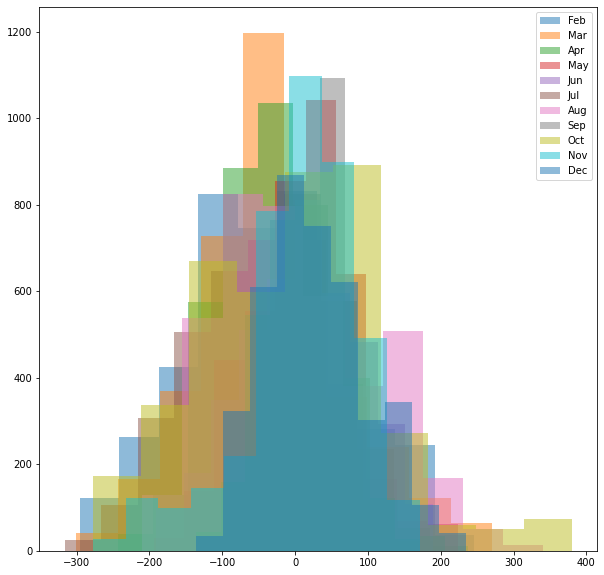

In [31]:
plt.figure(figsize=(10,10))
for i in range(0,11):
    plt.hist(fit['s_temp'].T[:,i,:], alpha=0.5,label=wheat_temp.columns[1:][i])
plt.legend()

Text(0.5, 1.0, 'Temp')

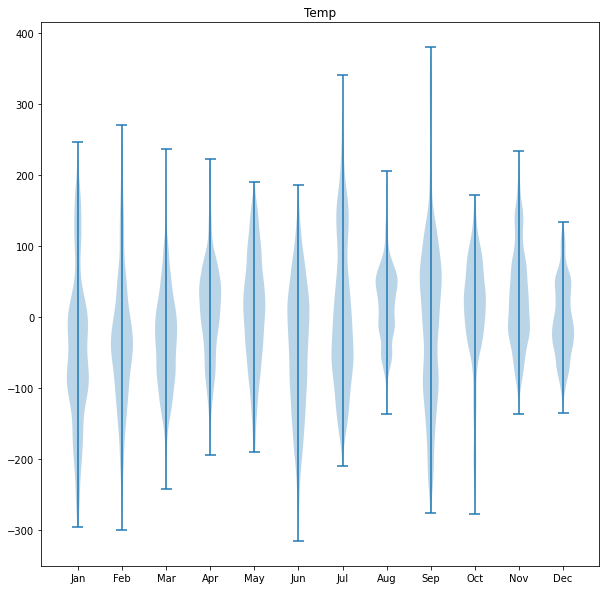

In [36]:
plt.figure(figsize=(10,10))
plt.violinplot(fit['s_temp'].T[:,:,0]);
plt.xticks(range(1,13),wheat_temp.columns);
plt.title('Temp')

Text(0.5, 1.0, 'Rainfall? seem swapped - check')

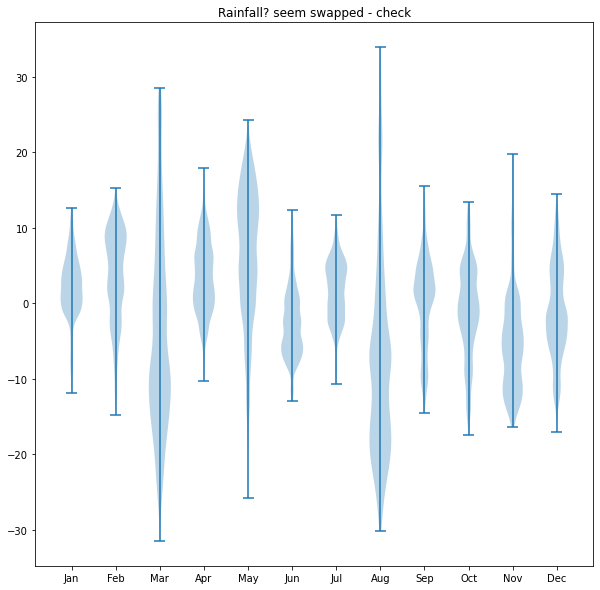

In [37]:
plt.figure(figsize=(10,10))
plt.violinplot(fit['s_precip'].T[:,:,0]);
plt.xticks(range(1,13),wheat_temp.columns);
plt.title('Rainfall? seem swapped - check')

## Step 3. Implement Bayesian model where predicted yield response is 2D Gaussian of T and P 

We are assuming that for a given month there is some optimum temperature and pressure and that the yield response is some function with a broad peak. Lts try to implement a 2D Gaussian. Crucially our data for a given year does not well cover the T, P plane about the peak of the Gaussian.

The k data points are 

$$
X_k = (Y_k, \boldsymbol T_k, \boldsymbol P_k)
$$

Where $\boldsymbol T_k$ and $\boldsymbol P_k$ are vectors with values for each month of the year. Under this model the monthly yield response will be 

$$
\begin{align}
\dot{y}(T,P)
& = \frac{\exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right)}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}}
\end{align}
$$

where

$$
\mu = [\mu_T,\mu_P]
$$

and

$$
\boldsymbol\Sigma =   \left[ {\begin{array}{cc}
   \Sigma_{TT} & \Sigma_{TP} \\
   \Sigma_{TP} & \Sigma_{PP} \\
  \end{array} } \right]
$$

or

$$
    \boldsymbol\Sigma = \left[ {\begin{array}{cc}
    \sigma_T^2 & \rho \sigma_T \sigma_P \\
    \rho \sigma_T \sigma_P  & \sigma_P^2 \\
    \end{array} } \right]
$$

Using the latter notation the function is

$$
\dot{y}_i ( T_i , P_i) = \frac{1}{2 \pi  \sigma_{T_i} \sigma_{P_i} \sqrt{1-\rho^2}}  \exp \left(  -\frac{1}{2(1-\rho^2)}\left[  \frac{(T_i-\mu_{T_i})^2}{\sigma_{T_i}^2} +  \frac{({P_i}-\mu_{P_i})^2}{\sigma_{P_i}^2} - \frac{2\rho({T_i}-\mu_{T_i} )({P_i}-\mu_{P_i})}{\sigma_{T_i} \sigma_{P_i}}  \right]  \right)
$$

The predicted yield is then

$$
Y = \sum_1^{12} n_i \dot{y}_i
$$

where, $n_i$ is a normalisation.

The liklihood (of one data point) is the probability of the data given the model

$$
P( Y, \boldsymbol{T}, \boldsymbol{P} | M(\mu_T,\mu_P,\Sigma_{TT},\Sigma_{TP},\Sigma_{PP}))
$$

But, we are assuming that we know $\boldsymbol{T}$ and $\boldsymbol{P}$ so the probability of one yield data point is 

$$
P( Y, | M(\mu_T,\mu_P,\Sigma_{TT},\Sigma_{TP},\Sigma_{PP},  \boldsymbol{T}, \boldsymbol{P}))
$$

In which case our liklihood is 

$$
\textrm{ln} \mathcal{L} = \sum_k \textrm{ln} N(Y - \sum_i n_i \dot{y}_i, \sigma )
$$


This model is in danger of having too many dummy parameters. Options for dealing with this are to assume the same shape for each month. This would be in agreement with a simple model that plants don't grow in winter because the temperature and precipitation conditions are not ideal. this would reduce the parameters by a factor of twelve. Another option is to fuly ignore some months since we know May to August seems to have the greatest effect on yields.

# First two dimensional model

In this example we implement the model described in detail above. We anticipate that moving forward we may want to limit the months and possibly enforce a similar shape across multiple regions or months.

In [43]:
with open('stan/BMSM-gaussian.stan', 'r') as f:
    model = f.read()
gm = stan.build(model, data)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_7a2id07b/model_5qg4bhkn.stan', line 54, column 42: Argument 1000.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_7a2id07b/model_5qg4bhkn.stan', line 53, column 46: Argument 1000.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_7a2id07b/model_5qg4bhkn.stan', line 52, column 46: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_7a2id07b/model_5qg4bhkn.stan', line 50, column 45: Argument 1000.0 suggests there may be parameter

In [44]:
fit=gm.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   3% (203/8000)
Sampling:   5% (402/8000)
Sampling:   9% (701/8000)
Sampling:  11% (901/8000)
Sampling:  15% (1201/8000)
Sampling:  18% (1400/8000)
Sampling:  21% (1700/8000)
Sampling:  25% (2000/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  52% (4200/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000135 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.35 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_

In [45]:
# fit
df = fit.to_frame()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4000.0,7166.638863,800.964319,5718.169242,7100.406661,7605.984566,7653.314712,7693.140753
accept_stat__,4000.0,0.794455,0.247354,0.000000,0.750000,0.888889,0.944444,0.991427
stepsize__,4000.0,0.020053,0.010301,0.005894,0.013341,0.020390,0.027102,0.033541
treedepth__,4000.0,2.693250,1.368803,0.000000,2.000000,3.000000,4.000000,6.000000
n_leapfrog__,4000.0,13.144500,12.691193,1.000000,4.000000,9.000000,18.000000,117.000000
...,...,...,...,...,...,...,...,...
rho.1.8,4000.0,-0.038473,0.529045,-0.913548,-0.473832,-0.222459,0.521846,0.824201
rho.1.9,4000.0,-0.178288,0.202211,-0.539254,-0.394665,-0.197759,-0.002868,0.314061
rho.1.10,4000.0,0.062575,0.552287,-0.704768,-0.458212,-0.121152,0.677333,0.972099


In [ ]:
samples=fit.extract()

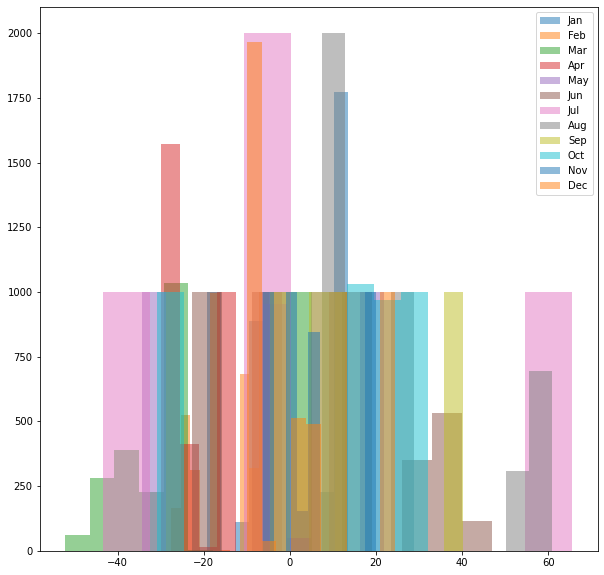

In [51]:
plt.figure(figsize=(10,10))
for i in range(0,12):
    plt.hist(fit['mu_t'].T[:,i,:], alpha=0.5,label=wheat_temp.columns[i])
plt.legend()

Text(0.5, 1.0, 'mu_p')

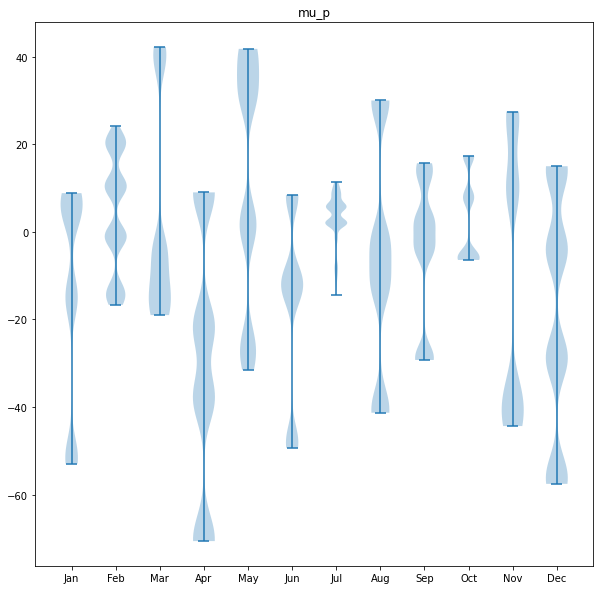

In [50]:
plt.figure(figsize=(10,10))
plt.violinplot(fit['mu_p'].T[:,:,0]);
plt.xticks(range(1,13),wheat_temp.columns);
plt.title('mu_p')

# Problems with this model
Clearly the model is failing. Perhaps this is due to the fact that we have far too many parameters and too little data. Lets try constraining the model to have a similar shape across months and regions as Peter did [Growth_curve_fitting.ipynb](./Growth_curve_fitting.ipynb)

## Read data

Here we copy Peter's code importing the anaomalies and converting to true temperatures and precipitation. the model fitting per mpnth doesn't require these but moving to a multi region fit does.

In [44]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import stan
import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

In [45]:
# Read in climate temperatures
clim_temp_maize=pd.read_table('./Crop_data_files/clim_file/temp_climatology_Maize.csv')
clim_temp_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)
# Read in climate precipitation
clim_precip_maize=pd.read_table('./Crop_data_files/clim_file/precip_climatology_Maize.csv')
clim_precip_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)
# Read in Yields
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [46]:
states=['Indiana','Illinois', 'Ohio','Nebraska', 'Iowa','Minnesota']

In [47]:
#Read in and add back mean temperature to get real temperature values
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_temp.iloc[:,1:].add(clim_temp_maize[clim_temp_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]].iloc[0,1:,])
    temp_states.append(tmp)
temp_states=pd.concat(temp_states,keys=states)

#Read in and add back mean precipitation to get real precipitation values
precip_states=[]
for i,s in enumerate(states):
    maize_precip=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_precip_anom_real.csv')
    maize_precip.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_precip.iloc[:,1:].add(clim_precip_maize[clim_precip_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]].iloc[0,1:,])
    precip_states.append(tmp)
precip_states=pd.concat(precip_states,keys=states)

In [50]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data2={
    'n_regions':len(states),
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,3:9]).reshape(
                     len(states),
                     int(np.array(temp_states.iloc[:,3:9]).shape[0]/len(states)),6
                                                      ).astype(float),
    'd_precip':np.array(precip_states.iloc[:,3:9]).reshape(
                     len(states),
                     int(np.array(precip_states.iloc[:,3:9]).shape[0]/len(states)),6
                                                      ).astype(float),
    'd_yields':np.array(yields[yields["Region"].isin(
                     ['Maize_Spring_USA_'+s for s in states]
                                                    )].iloc[:,22:]).astype(float)+6,
    'n_gf':40,
    'temp':np.arange(0,40,1),
    'precip':np.arange(0,200,5)

}

In [53]:
# with open('stan/2d-gaussian.stan', 'r') as f:
#     model = f.read()
#gm2 = pystan.StanModel(file='./stan/2d-gaussian.stan') 

with open('stan/2d-gaussian_with_correlation.stan', 'r') as f:
    model = f.read()

gm2 = stan.build(model, data2, random_seed=1308)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_f_rmjjos/model_en7ljgvm.stan', line 53, column 21: Argument 25 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_f_rmjjos/model_en7ljgvm.stan', line 52, column 22: Argument 25 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_f_rmjjos/model_en7ljgvm.stan', line 52, column 18: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_f_rmjjos/model_en7ljgvm.stan', line 50, column 18: Argument 20 suggests there may be parameters that are not

In [54]:
fit=gm2.sample(num_chains=4,num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (601/8000)
Sampling:   9% (701/8000)
Sampling:  10% (801/8000)
Sampling:  11% (901/8000)
Sampling:  13% (1001/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2901/8000)
Sampling:  38% (3001/8000)
Sampling:  39% (3101/8000)
Sampling:  40% (3201/8000)
Sampling:  41% (3301/8000)
Samplin

In [56]:
# fit
df = fit.to_frame()
df.describe().T


,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4000.0,-123.896470,1.701653,-133.744162,-124.786221,-123.553140,-122.629857,-121.032972
accept_stat__,4000.0,0.932106,0.094079,0.292621,0.906430,0.971551,0.994369,1.000000
stepsize__,4000.0,0.168256,0.004150,0.164479,0.164506,0.167022,0.170773,0.174501
treedepth__,4000.0,4.214750,0.588829,2.000000,4.000000,4.000000,5.000000,5.000000
n_leapfrog__,4000.0,22.881500,8.428566,3.000000,15.000000,27.000000,31.000000,63.000000
...,...,...,...,...,...,...,...,...
pred_yields.2.35,4000.0,5.591576,1.013629,2.146080,4.928562,5.582806,6.256160,9.367909
pred_yields.3.35,4000.0,6.947696,1.015649,3.588810,6.245814,6.955967,7.628610,11.532394
pred_yields.4.35,4000.0,5.749580,1.019914,2.128257,5.067029,5.763089,6.449561,9.272264


In [58]:
# from https://github.com/grburgess/stan_utility/blob/master/stan_utility/utils.py
def check_div(fit, quiet=False):
    """Check transitions that ended with a divergence"""
    # sampler_params = fit.sample_and_sampler_param_names
    # divergent = [x for y in sampler_params for x in y["divergent__"]]
    divergent = fit["divergent__"][0]
    n = sum(divergent)
    N = len(divergent)

    if not quiet and n > 0:
        print(
            "{} of {} iterations ended with a divergence ({}%)".format(
                n, N, 100 * n / N
            )
        )
        # return 'jokes'

    if n > 0:
        if not quiet:
            print("  Try running with larger adapt_delta to remove the divergences")
            # return 'here'
        else:
            return False
    else:
        if quiet:
            return True
        # else:
        #     return 'silly'


def check_treedepth(fit, max_treedepth=10, quiet=False):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    # depths = [x for y in sampler_params for x in y["treedepth__"]]
    depths = fit['treedepth__'][0]
    n = sum(1 for x in depths if x == max_treedepth)
    N = len(depths)

    if not quiet and n > 0:
        print(
            (
                "{} of {} iterations saturated the maximum tree depth of {}" + " ({}%)"
            ).format(n, N, max_treedepth, 100 * n / N)
        )
    if n > 0:
        if not quiet:
            print(
                "  Run again with max_treedepth set to a larger value to avoid saturation"
            )
        else:
            return False
    else:
        if quiet:
            return True


def check_energy(fit, quiet=False):
    """Checks the energy fraction of missing information (E-FMI)"""
    # sampler_params = fit
    no_warning = True
    for chain_num, energies in enumerate(fit['energy__']):
        # energies = s["energy__"]
        numer = sum(
            (energies[i] - energies[i - 1]) ** 2 for i in range(1, len(energies))
        ) / len(energies)
        denom = np.var(energies)
        if numer / denom < 0.2:
            if not quiet:
                print("Chain {}: E-BFMI = {}".format(chain_num, numer / denom))
            no_warning = False

    if no_warning:
        if quiet:
            return True
    else:
        if not quiet:
            print(
                "  E-BFMI below 0.2 indicates you may need to reparameterize your model"
            )
        else:
            return False

In [59]:
# carry out some diagnostic checks on fit
# from xidplus.stan_fit import stan_utility
check_div(fit)
check_energy(fit)
check_treedepth(fit)

In [24]:
samples=fit.extract()

In [60]:
fit['fdy1'].T.shape

(4000, 40)

Text(0, 0.5, '$dy$')

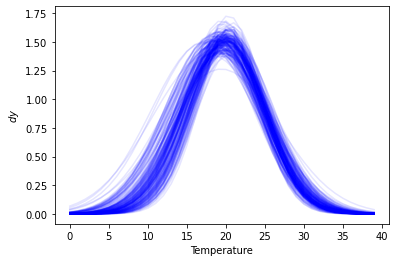

In [63]:
#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(data2['temp'],fit['fdy1'].T[i,:],alpha=0.1, c='b')
plt.xlabel('Temperature')
plt.ylabel(r'$dy$')
#plt.title('Growth Curve')

In [ ]:
#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(data2['precip'],fit['fdy2'].T[i,:],alpha=0.1, c='b')
plt.xlabel('precipitation')
plt.ylabel(r'$dy$')
#plt.title('Growth Curve')

ValueError: Must pass 2-d input. shape=(4000, 12, 2)

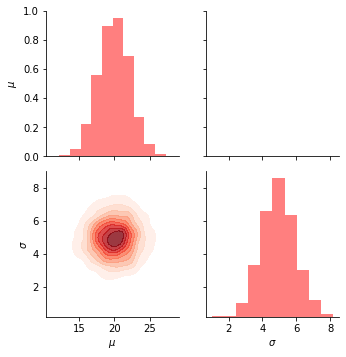

In [53]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([20,5]),np.array([[5.0,0.0],[0.0,1.0]]),2000),columns=['$\mu$','$\sigma$'])
g=sns.PairGrid(data=df,height=2.5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10, shade=True,thresh=0.05)
df=pd.DataFrame(np.vstack((fit['mu_t'],fit['sigma_t'])).T,columns=['$\mu$','$\sigma$'])
g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10, shade=True,thresh=0.05)

g.axes[0,1].set_axis_off()

# fig = g.get_figure()
# fig.savefig("./figs/2d_Gauss_prior_vs_post_temp_mean_vs_sigma.png")
# fig.savefig("./figs/2d_Gauss_prior_vs_post_temp_mean_vs_sigma.pdf")

ValueError: Must pass 2-d input. shape=(4000, 12, 2)

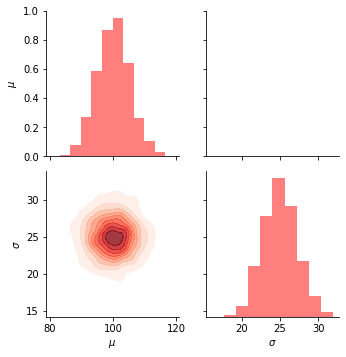

In [54]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([100,25]),np.array([[25.0,0.0],[0.0,5.0]]),2000),columns=['$\mu$','$\sigma$'])
g=sns.PairGrid(data=df,height=2.5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10, shade=True,thresh=0.05)
df=pd.DataFrame(np.vstack((fit['mu_p'],fit['sigma_p'])).T,columns=['$\mu$','$\sigma$'])
g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10, shade=True,thresh=0.05)

g.axes[0,1].set_axis_off()

# fig = g.get_figure()
# fig.savefig("./figs/2d_Gauss_prior_vs_post_precip_mean_vs_sigma.png")
# fig.savefig("./figs/2d_Gauss_prior_vs_post_precip_mean_vs_sigma.pdf")